# TestCase4 - Plots correction

In [1]:
# sélection du cas test
testcase = 4
version = 1
param_num = 1

In [ ]:
assert testcase == 4 and version == 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from testcases.utils import create_tree

from testcases.geometry.geometry_2D import Donut
from modfenics.fenics_expressions.fenics_expressions_2D import FExpr,UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [4]:
from testcases.networks.test_2D.test_4.test_4_v1 import Run_laplacian2D,Poisson_2D
from modfenics.solver_fem.solver_fem_4 import FEMSolver
from testcases.problem.problem_2D import TestCase4
problem = TestCase4(v=version)

result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cpu


2
[[-0.5, 0.500001], [-0.5, 0.500001]]
[[-0.5, 0.500001], [-0.5, 0.500001]]
>> load network /home/u2/lecourtier/Article1/networks/test_fe4_v7.pth
network loaded
Error  tensor([0.0006])


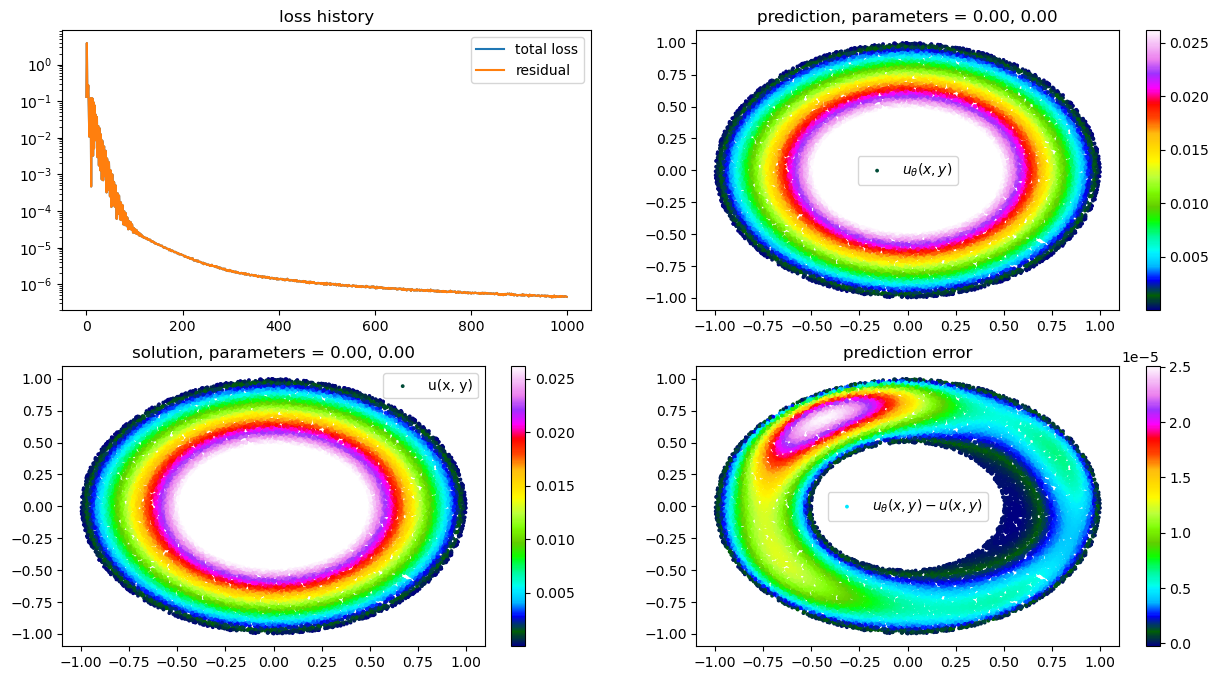

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22]


## Convergence FEM

In [8]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

hmax =  0.16663035129479017
nb_vert=16, norme_L2=0.008422057363026172
nb_vert=16, norme_L2=3.574562134093105e-05
hmax =  0.08691933730437637
nb_vert=32, norme_L2=0.0012202397883764
nb_vert=32, norme_L2=1.0175868040162316e-05
hmax =  0.04347038548979546
nb_vert=64, norme_L2=0.0003628726322204599
nb_vert=64, norme_L2=2.462605565184879e-06
hmax =  0.16663035129479017
nb_vert=16, norme_L2=0.00016672238916702294
nb_vert=16, norme_L2=2.2523967969926392e-06
hmax =  0.08691933730437637
nb_vert=32, norme_L2=2.1988239619369167e-05
nb_vert=32, norme_L2=3.1831695820526513e-07
hmax =  0.04347038548979546
nb_vert=64, norme_L2=2.604375903530348e-06
nb_vert=64, norme_L2=3.74003384337793e-08
hmax =  0.16663035129479017
nb_vert=16, norme_L2=3.004232302669339e-06
nb_vert=16, norme_L2=9.069075474934263e-08
hmax =  0.08691933730437637
nb_vert=32, norme_L2=1.3455439409505722e-07
nb_vert=32, norme_L2=6.258674068376265e-09
hmax =  0.04347038548979546
nb_vert=64, norme_L2=9.71049670536187e-09
nb_vert=64, norme

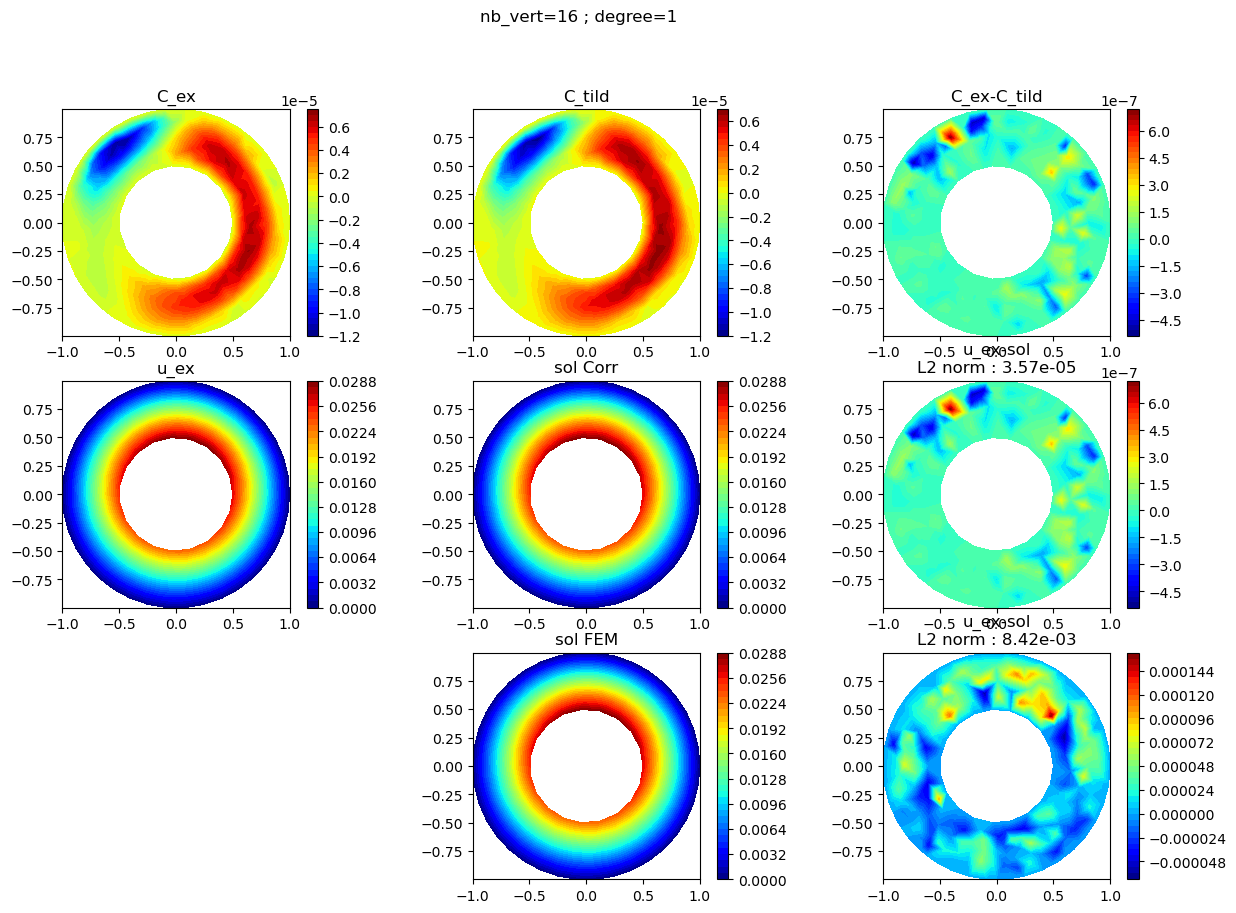

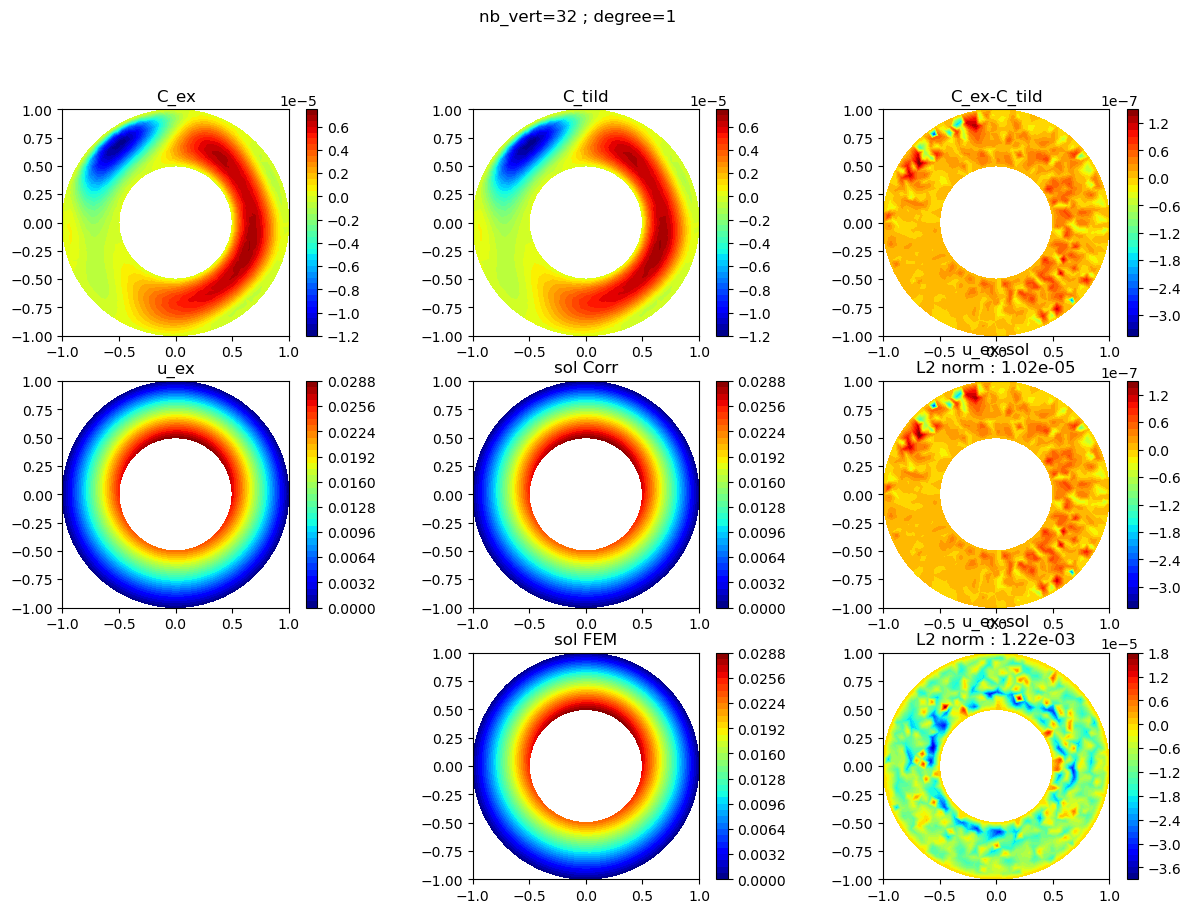

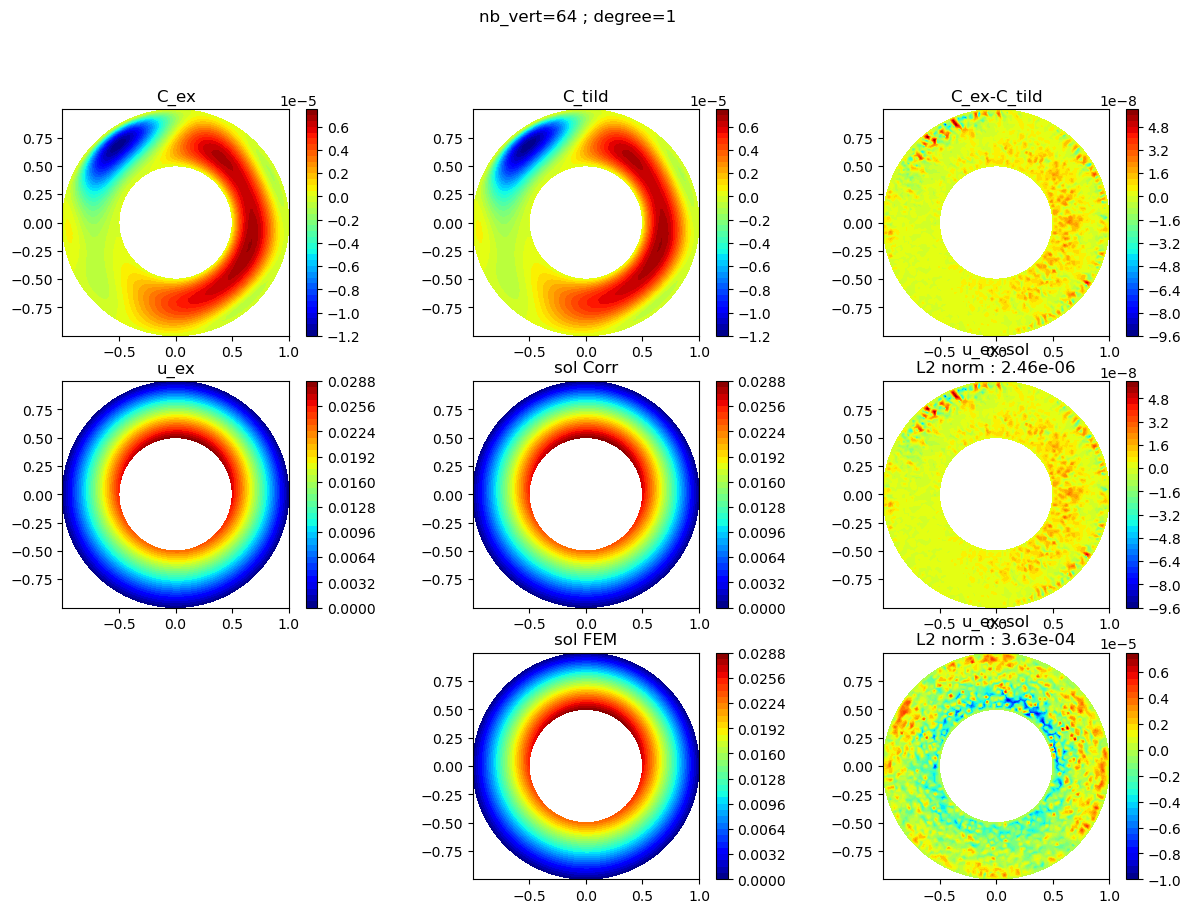

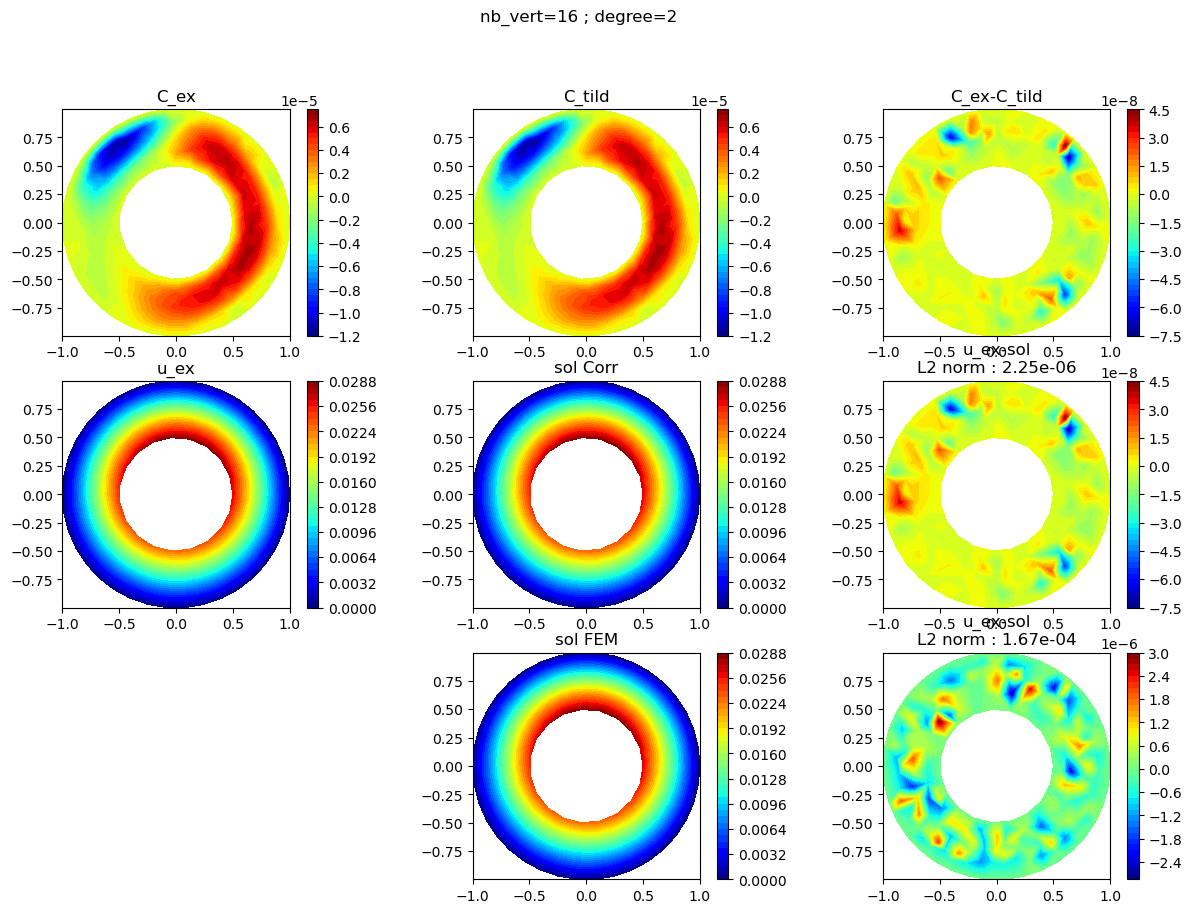

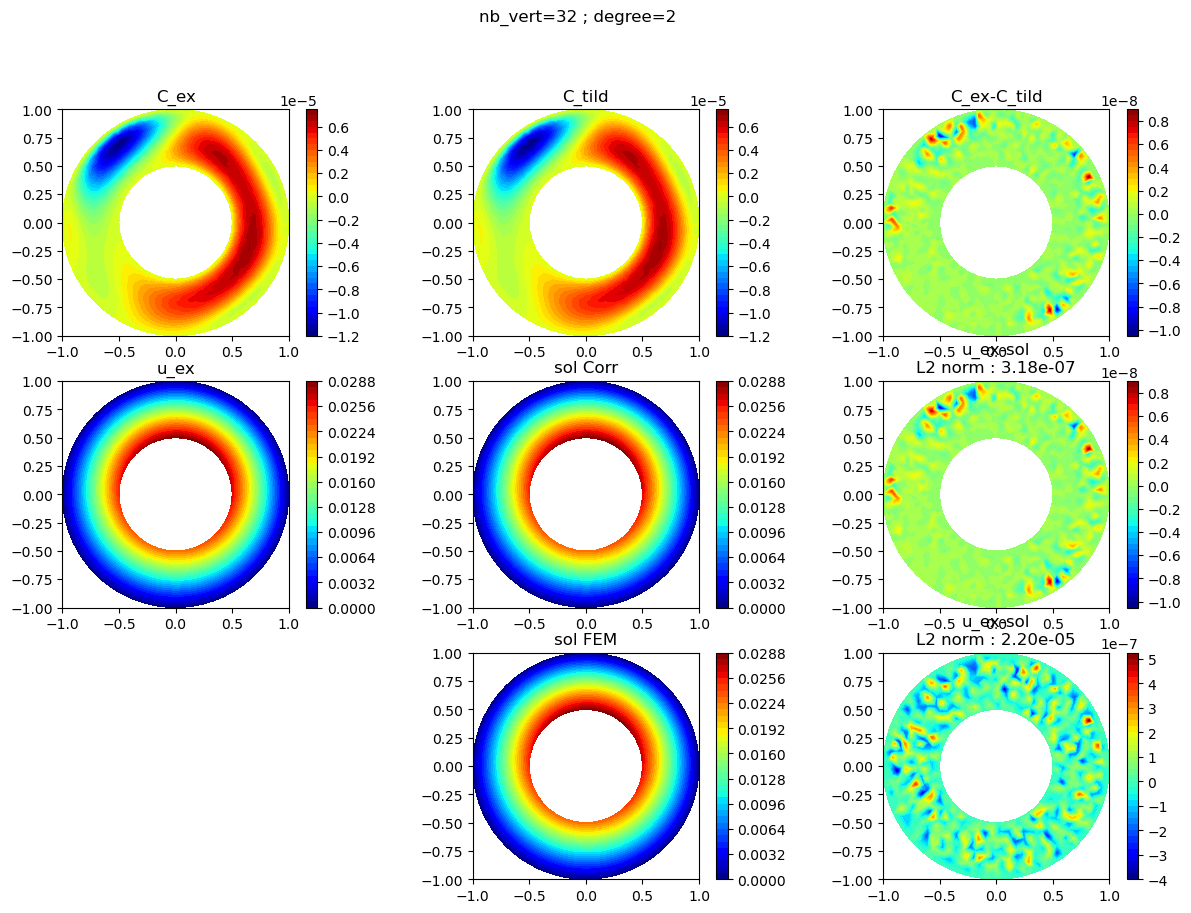

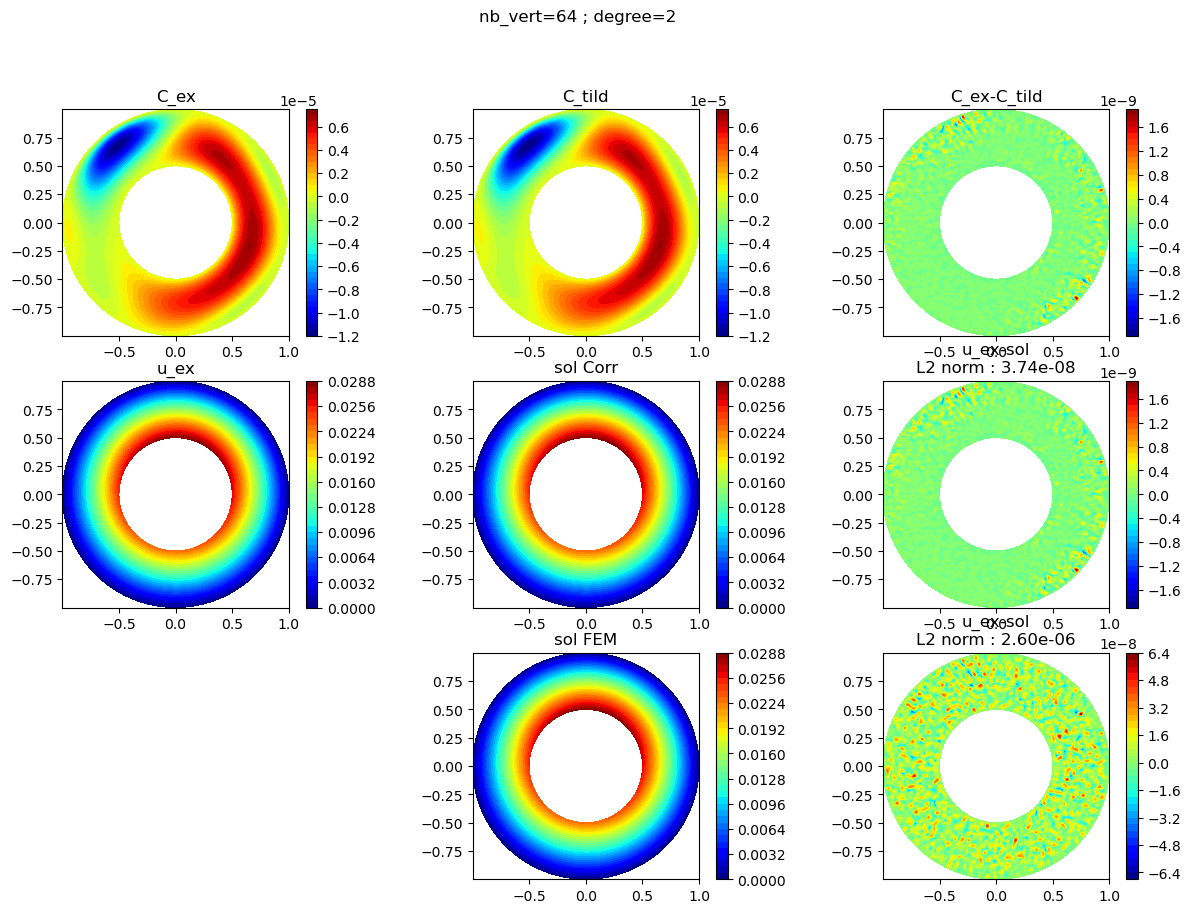

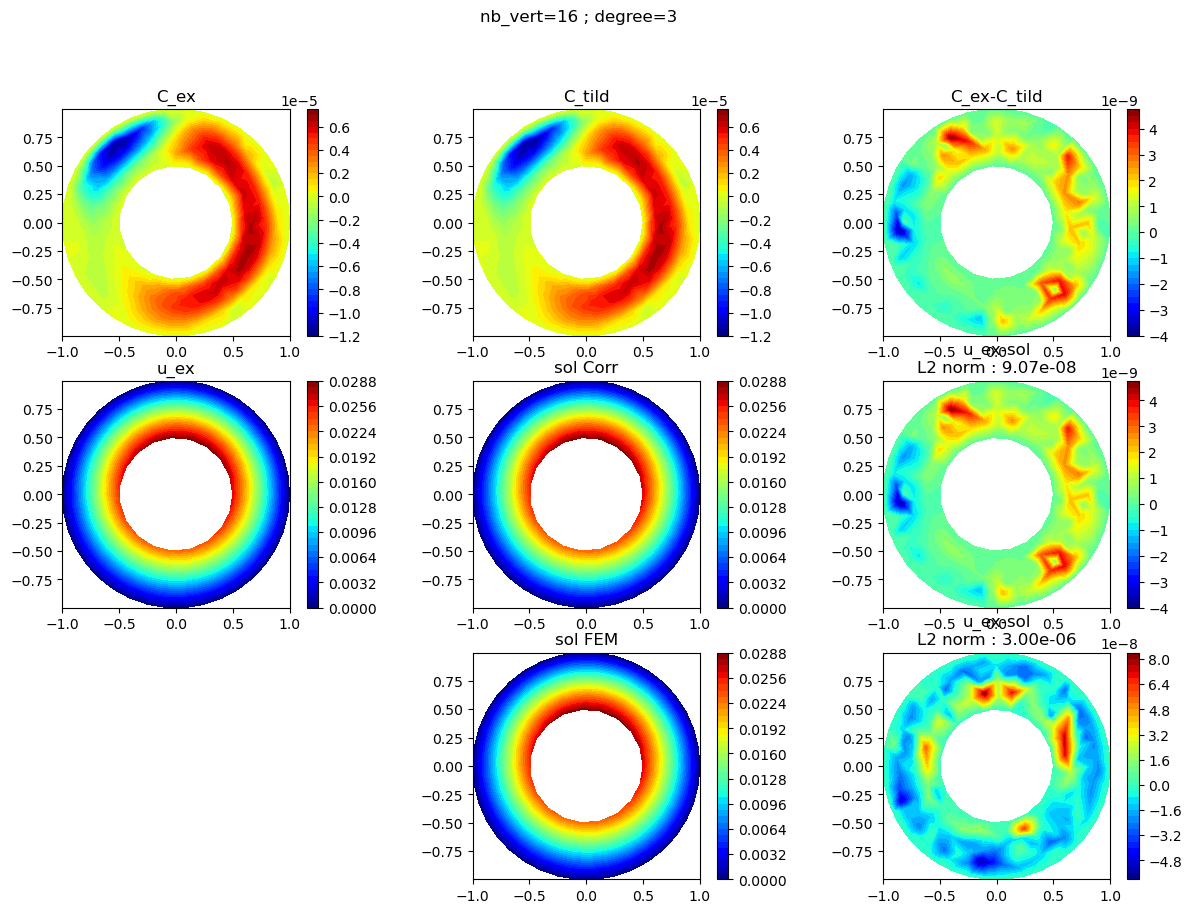

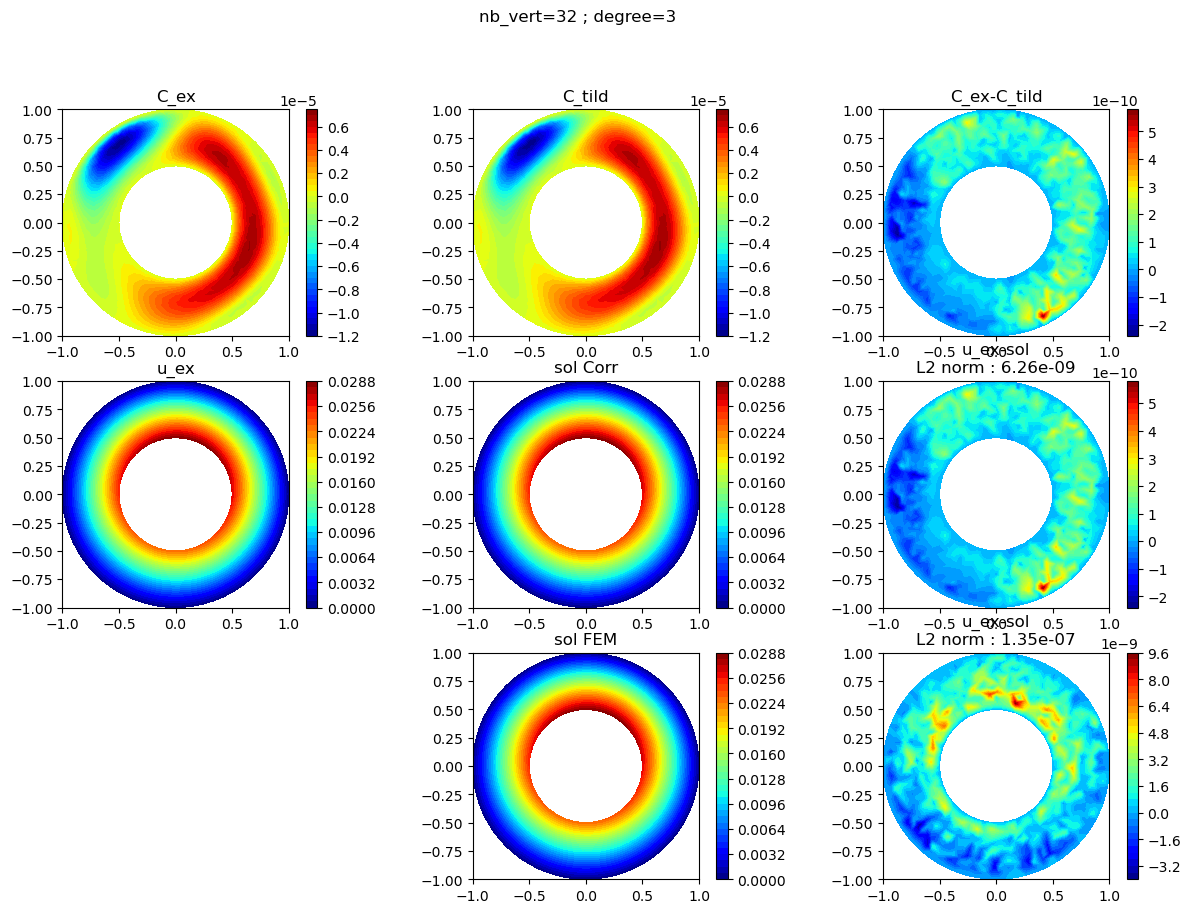

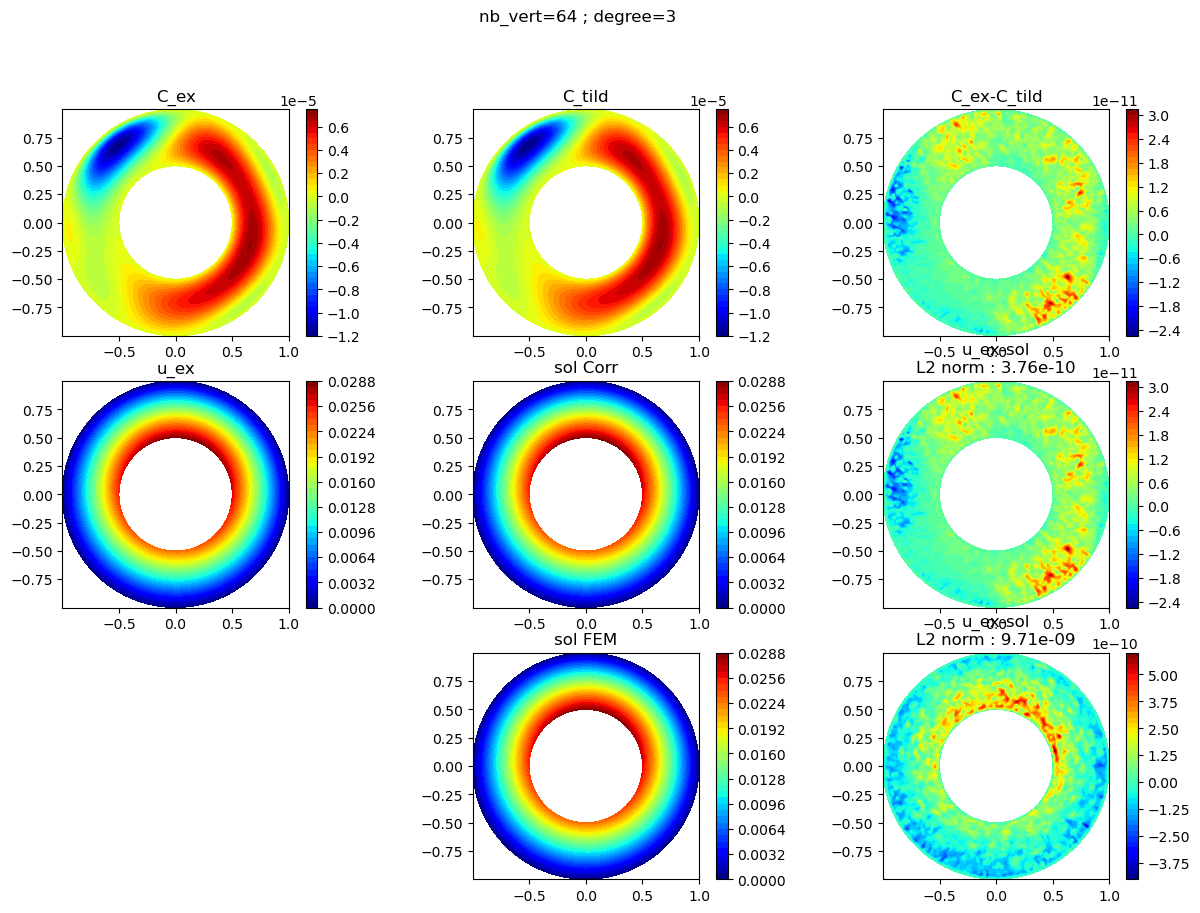

In [12]:
tab_nb_vert_FEM = [16,32,64]
tab_deg = [1,2,3]
degree_PINNs = 10

for degree in tab_deg:
    for nb_vert in tab_nb_vert_FEM:
        solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
        u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
        
        # FEM
        sol_FEM,norme_L2_FEM = solver.fem(0)
        print(f"nb_vert={nb_vert}, norme_L2={norme_L2_FEM}")
        
        # Compute PINNs solution
        V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
        u_PINNs = FEniCSpred(0,V_test,trainer)
        u_PINNs_inter = FEniCSpred(0,solver.V,trainer)
        sol,C_tild,norme_L2_Corr = solver.corr_add(0,u_PINNs,u_PINNs_inter)

        print(f"nb_vert={nb_vert}, norme_L2={norme_L2_Corr}")
        
        ### PLOTT
        colormap = "jet"

        C_ex = df.Function(solver.V)
        u_ref_inter = df.interpolate(u_ref,solver.V)
        C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_inter.vector()[:]

        plt.figure(figsize=(15,10))

        plt.subplot(3,3,1)
        c = df.plot(C_ex,cmap=colormap)
        plt.colorbar(c)
        plt.title("C_ex")

        plt.subplot(3,3,2)
        c = df.plot(C_tild,cmap=colormap)
        plt.colorbar(c)
        plt.title("C_tild")

        plt.subplot(3,3,3)
        error = df.Function(solver.V)
        error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
        c = df.plot(error,cmap=colormap)
        plt.colorbar(c)
        plt.title("C_ex-C_tild")

        plt.subplot(3,3,4)
        c = df.plot(u_ref_inter,cmap=colormap)
        plt.colorbar(c)
        plt.title("u_ex")

        plt.subplot(3,3,5)
        # sol_inter = df.project(sol,solver.V)
        sol_inter = df.Function(solver.V)
        sol_inter.vector()[:] = u_PINNs_inter.vector()[:] + C_tild.vector()[:]
        c = df.plot(sol_inter,cmap=colormap)
        plt.colorbar(c)
        plt.title("sol Corr")

        plt.subplot(3,3,6)
        error = df.Function(solver.V)
        error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
        c = df.plot(error,cmap=colormap)
        plt.colorbar(c)
        plt.title(f"u_ex-sol\nL2 norm : {norme_L2_Corr:.2e}")
        
        # FEM
        plt.subplot(3,3,8)
        sol_inter = df.interpolate(sol_FEM,solver.V)
        c = df.plot(sol_inter,cmap=colormap)
        plt.colorbar(c)
        plt.title("sol FEM")

        plt.subplot(3,3,9)
        error = df.Function(solver.V)
        error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
        c = df.plot(error,cmap=colormap)
        plt.colorbar(c)
        plt.title(f"u_ex-sol\nL2 norm : {norme_L2_FEM:.2e}")    

        plt.suptitle(f"nb_vert={nb_vert} ; degree={degree}")

        plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}_new.png')